# Importing Dependencies



In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

## Importing Dataset

In [2]:
dataset_columns = ["sentiment" , "id" , "time" , "flag" , "user" , "text" ]
dataset_coding = "ISO-8859-1"
dataset = pd.read_csv("training.1600000.processed.noemoticon.csv", names = dataset_columns , encoding = dataset_coding )

In [3]:
dataset.head()

,sentiment,id,time,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
print("Dataset size:", len(dataset))

Dataset size: 1600000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   time       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
dataset["sentiment"].unique()

array([0, 4])

In [7]:
dataset["sentiment"].nunique()

2

In [8]:
dataset["sentiment"].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [9]:
dataset.isnull().sum()

sentiment    0
id           0
time         0
flag         0
user         0
text         0
dtype: int64

## Preprocessing / Cleaning Text

In [10]:
nltk.download('stopwords')
all_stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/astha_kushwaha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def preprocess(tweet , stem = True):
    processedText = []
    
    urlPattern =  r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphanumericPattern = r'\w*\d\w*'
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    punc = r'[^\w\s]'
    
    tweet = tweet.lower()
    tweet = re.sub(urlPattern , '' , tweet)
    tweet = re.sub(userPattern , '' , tweet)
    tweet = re.sub(alphanumericPattern , '' , tweet)
    tweet = re.sub(sequencePattern , seqReplacePattern , tweet)
    tweet = re.sub(punc,"",tweet)
    
    tweet = tweet.split()   
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    all_stopwords = stopwords.words('english')
  
    
    for word in tweet:
            if word not in (all_stopwords):
                if stem:
                    processedText.append(ps.stem(word))
                else:
                    processedText.append(word)
    processedText = [lemmatizer.lemmatize(w, pos='a') for w in processedText]
                
    return " ".join(processedText)
    
        
   

      

In [12]:
cleared_dataset = dataset.sample(frac=1).reset_index(drop=True)
cleared_dataset = cleared_dataset.iloc[0:]
cleared_dataset.info()
cleared_dataset["sentiment"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   time       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


4    800000
0    800000
Name: sentiment, dtype: int64

In [13]:
import time
start_time = time.time()
#cleared_dataset = cleared_dataset.drop(cleared_dataset.index[0]).reset_index()
cleared_dataset = cleared_dataset.drop(['time','flag','user','id'],axis=1)
cleared_dataset["cleared_text"] = cleared_dataset["text"].apply(preprocess)
print("--- %s seconds ---" % (time.time() - start_time))
X = cleared_dataset['cleared_text']
print(X)

--- 465.4038529396057 seconds ---
0          marilyn manson new album high side low surpris...
1                            gah colleg aime ist break humph
2                     ill physic revis today anticlimax prom
3                         love much work much hope great day
4          okay im tell yall im watchin well histori channel
                                 ...                        
1599995    shake headno im team carra one strong resili o...
1599996                       here compani christma newslett
1599997    oh im glad peopl follow mayb ill ecelebr thoug...
1599998    sure nobodi safe donat jade think wonderful yo...
1599999                                     ye ill take mall
Name: cleared_text, Length: 1600000, dtype: object


In [14]:
cleared_dataset

,sentiment,text,cleared_text
0,4,Marilyn Manson's new album - The High Side Of ...,marilyn manson new album high side low surpris...
1,0,gAH! College at 10:45 and aimee is't here duri...,gah colleg aime ist break humph
2,0,I'll have to do some Physics revision today......,ill physic revis today anticlimax prom
3,0,@peanutgnome he loves me very much. He just wo...,love much work much hope great day
4,4,okay i'm not telling y'all what i'm watchin be...,okay im tell yall im watchin well histori channel
...,...,...,...
1599995,4,"@Koppite4004 *shaking head*No, no, no, NO!! I'...",shake headno im team carra one strong resili o...
1599996,4,Here's my company Christmas newsletter http:/...,here compani christma newslett
1599997,4,"Oh, and I'm glad that 100 people are following...",oh im glad peopl follow mayb ill ecelebr thoug...
1599998,4,@lumalfoy It sure is nobody is safe from it th...,sure nobodi safe donat jade think wonderful yo...


## Analysing Data

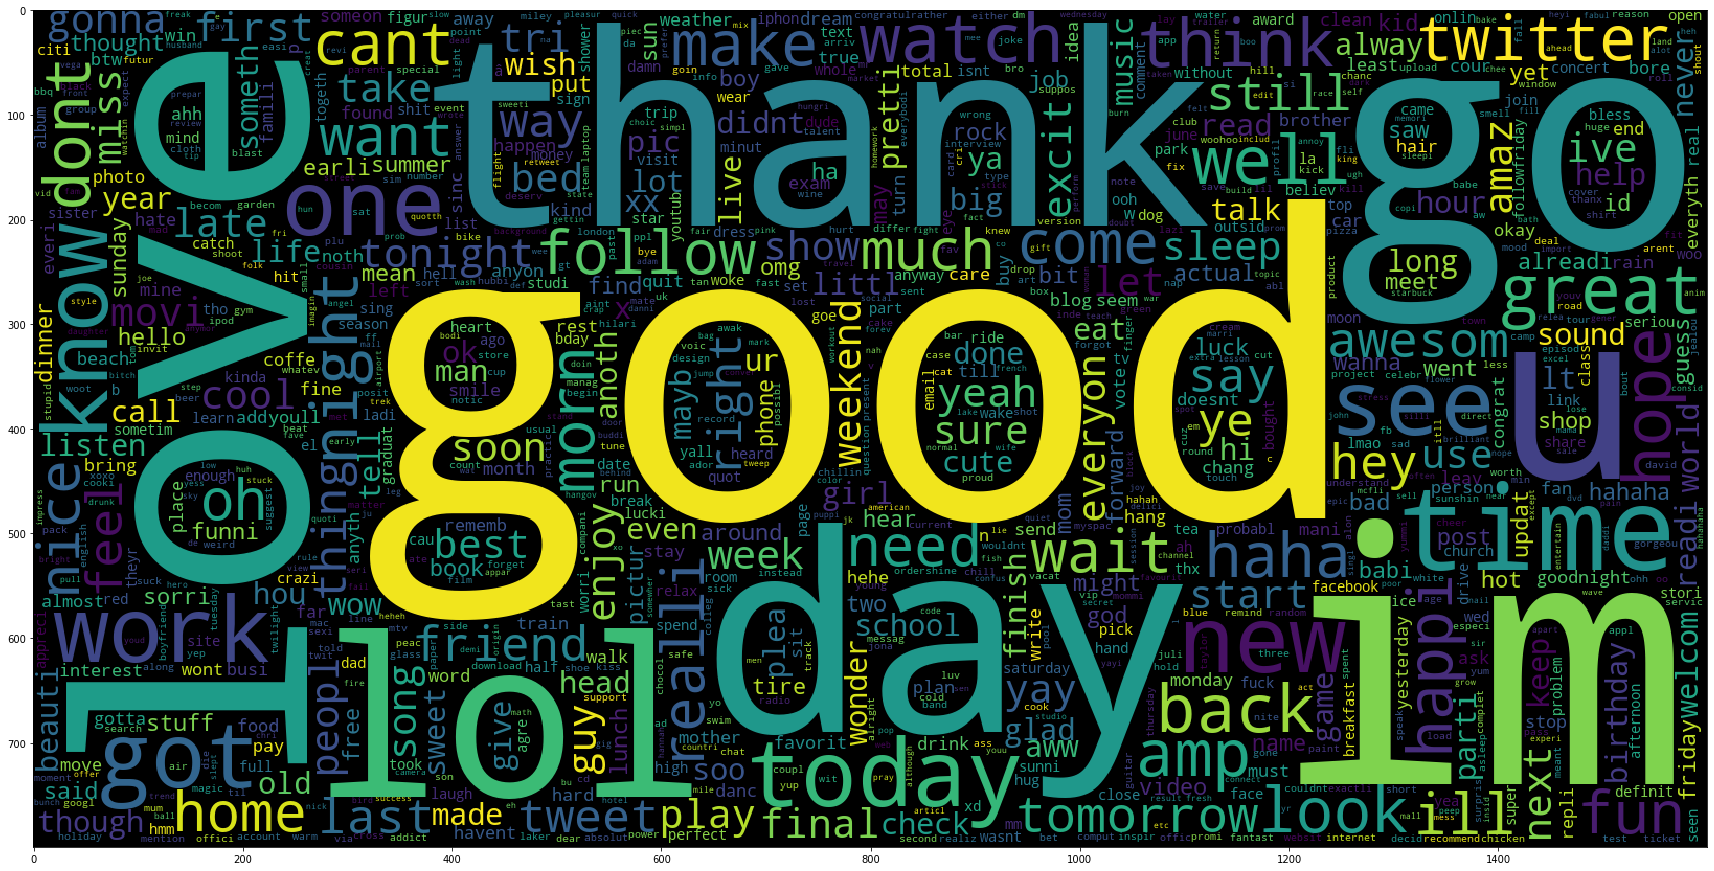

In [15]:
positive_tweet = cleared_dataset["cleared_text"][cleared_dataset["sentiment"]==4]
plt.figure(figsize = (30,30))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(",".join(map(str, positive_tweet)))
plt.imshow(wc)

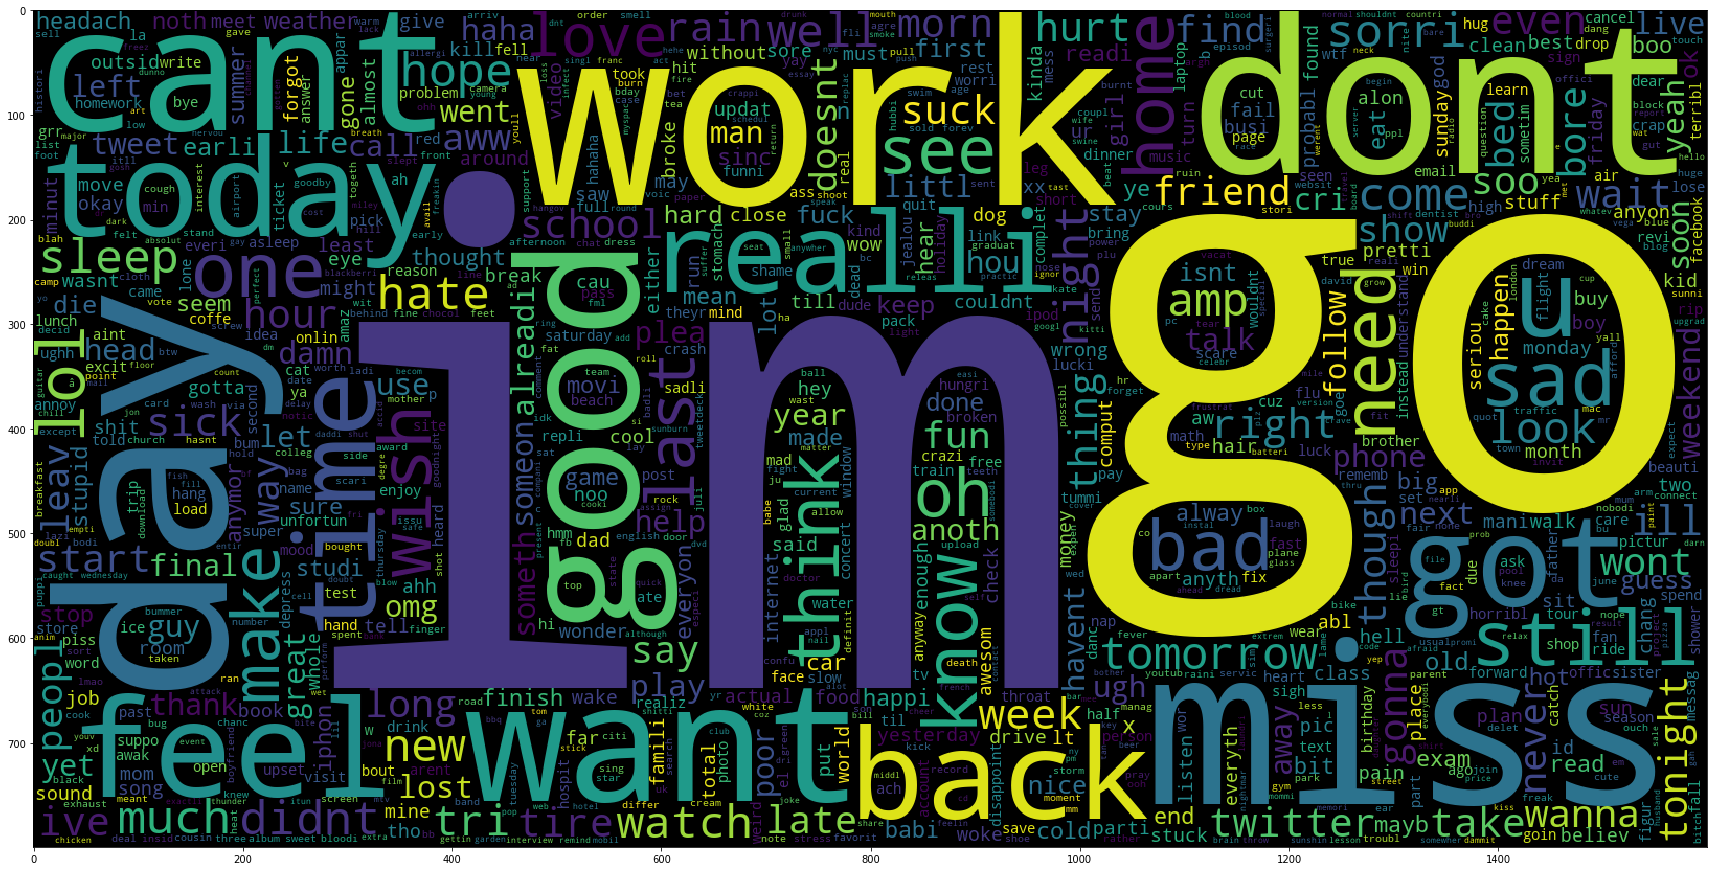

In [16]:
negative_tweet = cleared_dataset["cleared_text"][cleared_dataset["sentiment"]==0]
plt.figure(figsize = (30,30))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(",".join(map(str, negative_tweet)))
plt.imshow(wc)

## Splitting Dataset

In [ ]:
y = cleared_dataset['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.30, random_state = 10)

## TF - IDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word',max_df=0.90, min_df=2, max_features = 500000,ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train)
tfidf_tokens = vectorizer.get_feature_names()
print("Number of feature_words = ", len(tfidf_tokens))
print(tfidf_tokens[1:2000])



In [ ]:
X_test  = vectorizer.transform(X_test)

## Scaling

In [ ]:
x_max = X_train.max()
x_min = X_train.min()

X_train = (X_train - x_min)/x_max
X_test = (X_test - x_min)/x_max


## Model Evaluation

In [ ]:

def model(model):
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred = y_pred.values 
    y_test_ = pd.Series(y_test) 
    y_test_ = y_test_.values 
    #print("Comparison:")
    #result = np.concatenate((y_pred.reshape(len(y_pred),1), y_test_.reshape(len(y_test_),1)),1)
    #print(result[1:500])
    
    c_matrix = confusion_matrix(y_test_, y_pred)
    print("Confusion Matrix = \n",c_matrix)
    print("Accuracy Score = ",accuracy_score(y_test_, y_pred))
    print("Train Score = ",model.score(X_train, y_train))
    print("Test Score = ",model.score(X_test, y_test))
    
    
    
    categories = ['Negative','Positive']
    prediction = ['True Negative','False Positive', 'False Negative','True Positive']
    percentage = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

    labels = [f'{m}\n{n}' for m, n in zip(prediction,percentage)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(c_matrix,cmap = 'Blues' , fmt = '',annot = labels, xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title ("Confusion Matrix")
    
    

## Logistic Regression

In [ ]:
import time
start_time = time.time()
logistic_reg = LogisticRegression(solver = 'sag',C = 2, max_iter = 1500)
logistic_reg.fit(X_train, y_train) 
model(logistic_reg)
print("--- %s seconds ---" % (time.time() - start_time))

## Bernoulli Naive Bayes 

In [ ]:
start_time = time.time()
naive_bayes = BernoulliNB()
naive_bayes.fit(X_train, y_train) 
model(naive_bayes)
print("--- %s seconds ---" % (time.time() - start_time))

## Support Vector Machine

In [ ]:
start_time = time.time()
svm_model = LinearSVC()
svm_model.fit(X_train, y_train) 
model(svm_model)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
def predict_text(model,text):
    textdata = vectorizer.transform([preprocess(text)])
    sentiment = model.predict(textdata)
    
         
    df = pd.DataFrame(columns = ['text','sentiment'])
    df['text'] = text
    df['sentiment'] = sentiment
    df = df.replace([0,4], ["Negative","Positive"])
    return df

    

In [ ]:
if __name__=="__main__":
    text = "bd nit"
    df = predict_text(svm_model, text)
    print(df)